In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
from sklearn import linear_model


In [410]:
# load the provided data from loca file

data_path = r'C:/Users/agaworecki/Desktop/ML/MLND/Capstone Project/'
features = pd.read_csv(data_path +'dengue_features_train.csv')

labels = pd.read_csv(data_path +'dengue_labels_train.csv', index_col = [0])

## Investigate the Data

In [416]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [411]:
#Check out all the years in the training data
print(features.loc[features.city == 'sj'].groupby('year').first())

print(features.loc[features.city == 'iq'].groupby('year').count())

     city  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year                                                                            
1990   sj          18      1990-04-30  0.122600  0.103725  0.198483  0.177617   
1991   sj           1      1991-01-01  0.146500  0.140467  0.151500  0.167314   
1992   sj           1      1992-01-01  0.125100  0.157867  0.185283  0.181367   
1993   sj          53      1993-01-01  0.028350  0.043667  0.078657  0.046457   
1994   sj          52      1994-01-01 -0.120900  0.019300  0.094986  0.178514   
1995   sj          52      1995-01-01  0.243800  0.045000  0.215256  0.194778   
1996   sj           1      1996-01-01  0.014000  0.010867  0.091929  0.120443   
1997   sj           1      1997-01-01  0.152633  0.109400  0.207743  0.173286   
1998   sj           1      1998-01-01  0.045500  0.047800  0.123986  0.083443   
1999   sj          53      1999-01-01 -0.139900 -0.087600  0.188700  0.163417   
2000   sj          52      2

In [412]:
#how many missing data points are in the features dataset?
pd.isnull(features).sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

## What do the labels data look like?

In [473]:
#Split labels dataset by each city
sj_labels = labels.loc['sj']
iq_labels = labels.loc['iq']

#Get basic statistics for total_cases distribution for each city
print('San Juan')
print('mean: ', sj_labels.mean()[2])
print('var :', sj_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_labels.mean()[2])
print('var :', iq_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 27.165734265734248

Iquitos
mean:  7.565384615384615
var : 8.516377649325626


,year,weekofyear,total_cases
city,,,
sj,1990,18,4
sj,1990,19,5
sj,1990,20,4
sj,1990,21,3
sj,1990,22,6


Text(0.5,1,'San Juan: Dengue Fever Total Cases Per Week Time Series')

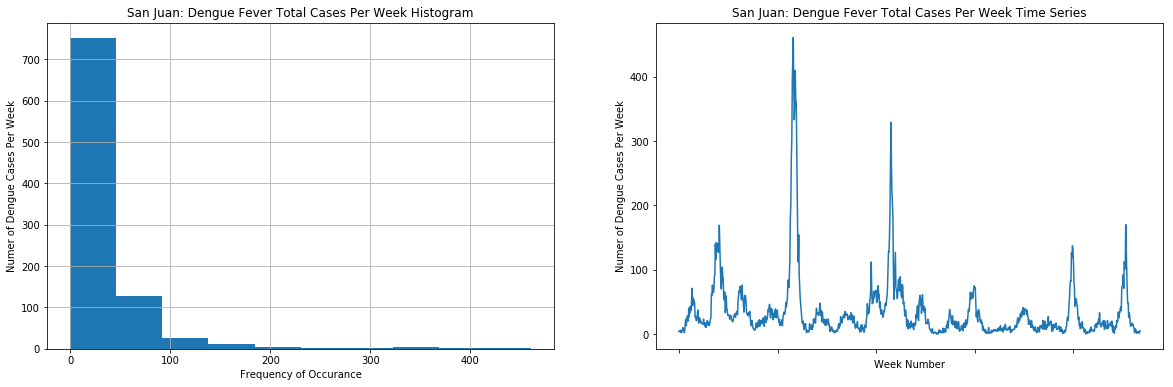

In [415]:
#SJ plots of labels
plt.subplot(1, 2, 1)
sj_labels.total_cases.hist()
plt.title('San Juan: Dengue Fever Total Cases Per Week Histogram')
plt.xlabel('Frequency of Occurance')
plt.ylabel('Numer of Dengue Cases Per Week')
plt.subplot(1,2,2)
sj_labels.total_cases.plot(figsize =(20,6))
plt.xlabel('Week Number')
plt.ylabel('Numer of Dengue Cases Per Week')
plt.title('San Juan: Dengue Fever Total Cases Per Week Time Series')

Text(0.5,1,'Iquitos: Dengue Fever Total Cases Time Series')

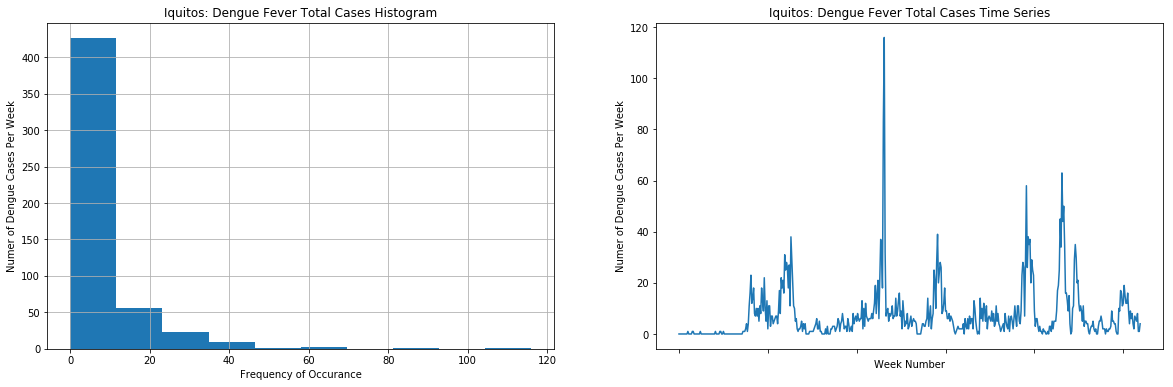

In [417]:
#IQ plots of labels
plt.subplot(1, 2, 1)
iq_labels.total_cases.hist()
plt.title('Iquitos: Dengue Fever Total Cases Histogram')
plt.xlabel('Frequency of Occurance')
plt.ylabel('Numer of Dengue Cases Per Week')
plt.subplot(1,2,2)
iq_labels.total_cases.plot(figsize =(20,6))
plt.xlabel('Week Number')
plt.ylabel('Numer of Dengue Cases Per Week')
plt.title('Iquitos: Dengue Fever Total Cases Time Series')

In [405]:
print('San Juan details')
print(labels.loc['sj'].describe())
print('Iquitos details')
print(labels.loc['iq'].describe())

San Juan details
              year  weekofyear  total_cases
count   936.000000  936.000000   936.000000
mean   1998.826923   26.503205    34.180556
std       5.212076   15.021909    51.381372
min    1990.000000    1.000000     0.000000
25%    1994.000000   13.750000     9.000000
50%    1999.000000   26.500000    19.000000
75%    2003.000000   39.250000    37.000000
max    2008.000000   53.000000   461.000000
Iquitos details
              year  weekofyear  total_cases
count   520.000000  520.000000   520.000000
mean   2005.000000   26.503846     7.565385
std       2.918283   15.029450    10.765478
min    2000.000000    1.000000     0.000000
25%    2002.750000   13.750000     1.000000
50%    2005.000000   26.500000     5.000000
75%    2007.250000   39.250000     9.000000
max    2010.000000   53.000000   116.000000


## Start Preprocessing

In [418]:
# create new variable to encode city label

is_sj = (features.city == 'sj').astype(int)
weekofyear = features.weekofyear
# extract the month data from 'weekofyear'
def extract_month(s):
    return int(s[5:7])

months = features.week_start_date.apply(extract_month)

#drop all location and timestamp columns
years = features.year
features.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)

In [419]:
#delete the column with approx. 20% NaN
features.drop(['ndvi_ne','ndvi_nw'], axis=1, inplace=True)

In [420]:
# impute the remaining missing values
features.interpolate(inplace=True)

In [363]:
#sanity check
features.head()

,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [421]:
# Create the df with lagged features
def create_lagged_features(df, lag=1):
    ''' Function to created lagged features'''
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
           
    # add i number of lagged columns for each feature in df
    for feature in df.columns.tolist():
        for i in range(1, lag + 1):
            df = df.join(df[feature].shift(i).pipe(_rename_lag, i)).fillna(df[feature].mean())
            #df.fillna(method = 'bfill', axis = 0, inplace=True)
    
    return df

# example series
features_lagged = create_lagged_features(features, 6)

In [424]:
#Add in time series proxy data 'weekofyear' and 'month'
#'is_sj' just used to split features dataset
features_lagged['is_sj'] = is_sj
features_lagged['weekofyear'] = weekofyear
features_lagged['month'] = months

#split features dataset for each city
sj_features = features_lagged.loc[features_lagged.is_sj == 1]
iq_features = features_lagged.loc[features_lagged.is_sj == 0]
#split labels dataset for each city
sj_labels = labels.loc['sj']
iq_labels = labels.loc['iq']

#drop 'is_sj' column from datasets
sj_features.drop(['is_sj'], axis=1, inplace=True)
iq_features.drop(['is_sj'], axis=1, inplace=True)


In [425]:
#sanity check
sj_features.shape

(936, 128)

In [426]:
#standardize features for LASSO regression
def get_standard(df):
    scaler = StandardScaler()
    df_scaler = scaler.fit(df)
    df_scaled = scaler.transform(df)
    return df_scaled, df_scaler
    
sj_scaled, sj_scaler = get_standard(sj_features)    
iq_scaled, iq_scaler = get_standard(iq_features)  

## Get Best Features

In [427]:
#Get best features for SJ
#initialize list for all features to keep
sj_selected = []
#create Lasso model --> find best alpha
clf = linear_model.Lasso(alpha = 2.1)
clf.fit(sj_scaled, sj_labels.total_cases)
#loop through all coefficients to find the keepers
for i, coef in enumerate(clf.coef_.astype(list)):
    #print(i)
    if abs(coef) > 0:
        print(i, coef, sj_features.columns.astype(list)[i])
        sj_selected.append(sj_features.columns.astype(list)[i])


0 -0.46624297775380896 ndvi_se
1 0.596533465058631 ndvi_sw
4 -0.38285760064093277 reanalysis_avg_temp_k
14 2.1237024974629857 station_diur_temp_rng_c
18 -1.4411016112758255 ndvi_se_1
19 -1.553818575839077 ndvi_se_2
20 -0.2041353711375777 ndvi_se_3
24 1.4300238437270243 ndvi_sw_1
25 1.2445235491116633 ndvi_sw_2
27 0.13284931622840337 ndvi_sw_4
28 0.09069205174911552 ndvi_sw_5
29 0.09700083520764788 ndvi_sw_6
59 1.3250689327084535 reanalysis_max_air_temp_k_6
91 -0.28845535030866754 reanalysis_tdtr_k_2
92 -0.37941334380222796 reanalysis_tdtr_k_3
93 -0.9139779115505037 reanalysis_tdtr_k_4
94 -1.1567125575123551 reanalysis_tdtr_k_5
95 -2.7331648573113556 reanalysis_tdtr_k_6
110 0.7604919993599514 station_max_temp_c_3
111 1.431595759169119 station_max_temp_c_4
112 1.8686571145559692 station_max_temp_c_5
113 2.136712031161972 station_max_temp_c_6
118 3.5318961867823195 station_min_temp_c_5
119 7.360588396103023 station_min_temp_c_6
126 1.0387432350536445 weekofyear
127 0.6703944739905277 mont

In [428]:
#Get best features for IQ

iq_selected = []

clf = linear_model.Lasso(alpha = 1.1)
clf.fit(iq_scaled, iq_labels.total_cases)
#print(clf.coef_)
for i, coef in enumerate(clf.coef_.astype(list)):
    #print(i)
    if abs(coef) > 0.:
        print(i, coef, iq_features.columns.astype(list)[i])
        iq_selected.append(iq_features.columns.astype(list)[i])
print(iq_selected)


7 0.10703462169692404 reanalysis_min_air_temp_k
11 0.534939767596847 reanalysis_specific_humidity_g_per_kg
16 0.21387318370518119 station_min_temp_c
84 0.16295901682036562 reanalysis_specific_humidity_g_per_kg_1
85 0.3507118122763167 reanalysis_specific_humidity_g_per_kg_2
86 0.19631513242608858 reanalysis_specific_humidity_g_per_kg_3
88 0.03936937056874225 reanalysis_specific_humidity_g_per_kg_5
110 0.0053386251054025015 station_max_temp_c_3
113 0.16764006762159864 station_max_temp_c_6
114 0.3332977817331154 station_min_temp_c_1
115 0.011716789228639233 station_min_temp_c_2
['reanalysis_min_air_temp_k', 'reanalysis_specific_humidity_g_per_kg', 'station_min_temp_c', 'reanalysis_specific_humidity_g_per_kg_1', 'reanalysis_specific_humidity_g_per_kg_2', 'reanalysis_specific_humidity_g_per_kg_3', 'reanalysis_specific_humidity_g_per_kg_5', 'station_max_temp_c_3', 'station_max_temp_c_6', 'station_min_temp_c_1', 'station_min_temp_c_2']


In [438]:
#Keep only the features 'selected' by Lasso
sj_features = sj_features.loc[:, sj_selected]
iq_features = iq_features.loc[:, iq_selected]

#standardize the features --> convert back to df
sj, _ = get_standard(sj_features)
sj_features = pd.DataFrame(sj, columns = sj_features.columns)
iq, _ = get_standard(iq_features)
iq_features = pd.DataFrame(iq, columns = iq_features.columns)


#add the labels to the training dataset for NBR modeling
sj_features['total_cases'] = sj_labels.total_cases.values
iq_features['total_cases'] = iq_labels.total_cases.values

sj_X_train, sj_X_valid, sj_y_train, sj_y_valid = train_test_split(sj_features, sj_labels, shuffle = False, test_size = 0.4)
iq_X_train, iq_X_valid, iq_y_train, iq_y_valid = train_test_split(iq_features, iq_labels, shuffle = False, test_size = 0.4)
print(sj_X_train.shape)
print(sj_X_valid.shape)
print(iq_X_train.shape)
print(iq_X_valid.shape)

(561, 27)
(375, 27)
(312, 12)
(208, 12)


## Traing the NBR Model

In [439]:
# Train the model on selected lagged features 

from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    
    formula_list = list(train.columns)
    formula_list.remove('total_cases')
    formula = ' + '.join([str(i) for i in formula_list])
    model_formula = 'total_cases ~ +' + formula


    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_X_train, sj_X_valid)
#Get error metric on complete training data predictions
#final_score = eval_measures.meanabs(sj_best_model.fittedvalues, sj_select.total_cases)
#print('Final score SJ = ',final_score)

iq_best_model = get_best_model(iq_X_train, iq_X_valid)
#Get error metric on complete training data predictions
#final_score = eval_measures.meanabs(iq_best_model.fittedvalues, iq_select.total_cases)
#print('Final score IQ = ',final_score)

best alpha =  0.0001
best score =  26.013333333333332
best alpha =  1e-08
best score =  6.4423076923076925


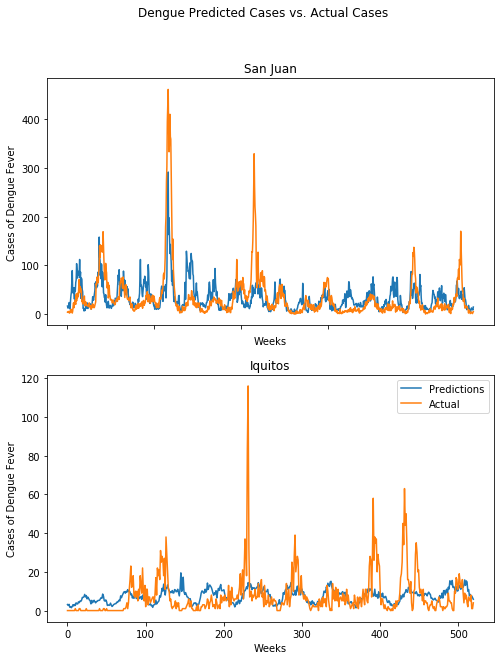

In [469]:
#Plot predcitions vs total_cases to compare visually

figs, axes = plt.subplots(nrows=2, ncols=1, figsize = (8,10))

# plot sj
sj_best_model.fittedvalues.plot(ax=axes[0], label="Predictions")
sj_labels.total_cases.plot(ax=axes[0], label="Actual")
axes[0].set_title('San Juan')
axes[0].set_xlabel('Weeks')
axes[0].set_ylabel('Cases of Dengue Fever')

# plot iq
iq_best_model.fittedvalues.reset_index(drop=True).plot(ax=axes[1], label="Predictions")
iq_labels.reset_index().total_cases.plot(ax=axes[1], label="Actual")
axes[1].set_title('Iquitos')

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()
plt.ylabel('Cases of Dengue Fever')
plt.xlabel('Weeks')

plt.savefig('predictions.png', bbox_inches='tight')
plt.show()

In [442]:
# preprocess for LASSO REGRESSION MODEL

def create_lagged_features(df, lag_week =6):  
    '''Function to create lagged features'''
        
    # add i number of lagged columns for each feature in df
    for feature in df.columns.tolist():
        fill_num = df[feature].mean()
        for i in range(1, lag_week + 1):
            df = df.join(df[feature].shift(i).pipe(_rename_lag, i)).fillna(fill_num)
    return df

def preprocess_data_lasso(data_path, labels_path=None, train = False):
    '''Function to do all the preprocessing'''
    df = pd.read_csv(data_path)
    
    is_sj = (df.city == 'sj').astype(int)

    # extract the month data from 'weekofyear' features
    months = df.week_start_date.apply(extract_month)
    weekofyear = df.weekofyear
    
    #drop all location and timestamp columns
    df.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)
    
    #delete the column with approx. 20% NaN
    df.drop(['ndvi_ne','ndvi_nw'], axis=1, inplace=True)
    
    # impute the remaining missing values
    df.interpolate(inplace=True)
      
    # create lagged features for 6 weeks into the past
    df_lagged = create_lagged_features(df, lag_week = 6)
    
    # add the features 'month','is_sj','weekofyear' to df_lagged
    df_lagged['month'] = months
    df_lagged['is_sj'] = is_sj
    df_lagged['weekofyear'] = weekofyear
  
    # add total_cases column as target - for training ONLY
    if train:
        labels = pd.read_csv(labels_path, index_col = [0])
        labels = labels.loc[labels.year > cutoff_year]
        #choose only more recent years to use for training model
        df_lagged = df_lagged.loc[df_lagged.year > cutoff_year]
        #select the best features to include in model
        #df_lagged = feature_selector(df, num_features)
    
        sj_labels = labels.loc['sj']
        iq_labels = labels.loc['iq']
        
    #Split into 2 dataset, for SJ and IQ
    sj_lagged = df_lagged.loc[df_lagged.is_sj ==1]
    iq_lagged = df_lagged.loc[df_lagged.is_sj ==0]
       
    #drop columns that indicate city label
    sj_lagged.drop('is_sj', axis = 1, inplace=True)
    iq_lagged.drop('is_sj', axis = 1, inplace=True)
    
    #choose only the Lasso selected features for prediction
    sj_lagged = sj_lagged.loc[:, sj_selected]
    iq_lagged = iq_lagged.loc[:, iq_selected]
    
    #standardize the features --> convert back to df
    #use get_standard function
    sj, _ = get_standard(sj_lagged)
    sj_lagged = pd.DataFrame(sj, columns = sj_lagged.columns)
    iq, _ = get_standard(iq_lagged)
    iq_lagged = pd.DataFrame(iq, columns = iq_lagged.columns)
    
    #return labels df only if training data
    if train:
        return sj_lagged, iq_lagged, sj_labels, iq_labels
    else:
        return sj_lagged, iq_lagged

## Save Results for Submission

In [461]:
#LASSO predictions and create submission file
sj_test, iq_test = preprocess_data_lasso(data_path +'dengue_features_test.csv')
print(sj_test.shape)
print(iq_test.shape)

#make predictions for each city data using best model
sj_preds = round(sj_best_model.predict(sj_test)).astype(int)
iq_preds = round(iq_best_model.predict(iq_test)).astype(int)
#concat predictions into one df
total_preds = pd.concat([sj_preds,iq_preds])
#load submission df for formatting
submission = pd.read_csv(data_path + "submission_format.csv")
#Add predictions as 'total_cases' column
submission['total_cases'] = total_preds.values
submission.set_index(['city','year','weekofyear'], inplace = True)

#Save submission formatted predictions to csv locally 
submission.to_csv(data_path + "my_submission_nbr_lagged_lasso_04.csv")

(260, 26)
(156, 11)
